# Plynty Bureau of Labor Statistics Consumer Expenditure Analysis

[BLS Comsumer Expenditure Survey](https://www.bls.gov/cex/home.htm)

[Interview Data Dictionary](https://www.bls.gov/cex/2015/csxintvwdata.pdf)

### Where to download the BLS CE PUMD
- The zip files download automatically
- To download the Stub files open the links then right click and choose "Save As..."

[2015 interview zip file](https://www.bls.gov/cex/pumd/data/comma/intrvw15.zip)

[2014 interview zip file](https://www.bls.gov/cex/pumd/data/comma/intrvw14.zip)

[2013 interview zip file](https://www.bls.gov/cex/pumd/data/comma/intrvw13.zip)

[2015 IntStub file](https://www.bls.gov/cex/pumd/2014/csxintstub.txt)

[2015 IStub file](https://www.bls.gov/cex/pumd/2014/csxistub.txt)

[2015 DStub file](https://www.bls.gov/cex/pumd/2014/csxdstub.txt)

### This Scripts Goals for Plynty
- Create an easy to use analysis script for the BLS CE PUMD 
- Create csv files that has average percentages spent on plynty categories for certain income classes
- Compare the Family CUs vs the Single person CUs

#### Importing Dependencies

In [1]:
print("Importing Dependencies")

import pandas as pd
import numpy as np
import os
import subprocess
from copy import deepcopy
import matplotlib.pyplot as plt
from BLSFunctions import *

Importing Dependencies


# Setting Variables

In [2]:
print("Setting Variables")

years = ["13","14","15"]
filesToRead = ["fmli", "mtbi"]

minAge = 60
maxAge = 75

familyIncomeBrackets = [-10000000, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000, 130000, 140000, 160000, 180000, 210000, 240000, 290000, 9980000]
singleIncomeBrackets = [-10000000, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 90000, 120000, 9980000]

pumdDir = "./CE_PUMD/"

Setting Variables


# Reading in Stubfiles

In [3]:
print("Reading in Stubfiles")

# Directory where stubfiles are located
pathToStubFileDir = "./Stubfiles/"
rScriptStubfilePathAndName = "./creatingStubCsvs.R"

stubFileDict = {}
stubFileDict["IStub"] =  "IStub2015.txt"
stubFileDict["DStub"] =  "DStub2015.txt"
stubFileDict["IntStub"] =  "IntStub2015.txt"

if os.path.isfile(pathToStubFileDir+"DStub.csv") and os.path.isfile(pathToStubFileDir+"IStub.csv") and os.path.isfile(pathToStubFileDir+"IntStub.csv"):
    print("Stubfiles Exist")
else:
    # converting the stub files via R 
    subprocess.call("Rscript "+rScriptStubfilePathAndName+" "+pathToStubFileDir+" "+stubFileDict["IStub"]+" "+stubFileDict["DStub"]+" "+stubFileDict["IntStub"], shell=True)
    print("Stubfile Csvs created in "+pathToStubFileDir)
    
# reading and cleaning the stubfiles    
for key in stubFileDict.keys():
    stubFileDict[key] = pd.read_csv(pathToStubFileDir+key+".csv")
    stubFileDict[key] = stubFileDict[key].drop(stubFileDict[key].columns[0], axis=1)
    stubFileDict[key].loc[stubFileDict[key].level == "*", 'level'] = 0

Reading in Stubfiles
Stubfiles Exist


# Creating the Data dictionary
output:
   - data (dictionary)
      - key: filenameYear
      - value: dataframe

In [4]:
print("Creating the Data dictionary")

data = {}
for year in years:
    yearDir = pumdDir+"intrvw"+year+"/intrvw"+year+"/"
    for file in filesToRead:
        print("Reading "+file+year)
        dataframe = readFileSet(file,yearDir)
        data[file+year] = dataframe
        
fmli = pd.concat([value for key,value in data.items() if 'fmli' in key.lower()], ignore_index=True)

Creating the Data dictionary
Reading fmli13
Reading mtbi13
Reading fmli14
Reading mtbi14
Reading fmli15
Reading mtbi15


# Creating Subset NEWID dictionary
output:
- subsetNEWIDs
 - key: Subset Category
 - value: dictionary or list of NEWIDs associated with the subset

In [5]:
print("Creating Subset NEWID dictionary")

subsetNEWIDs = {}
subsetNEWIDs["Age"] = []
subsetNEWIDs["Family"] = []
subsetNEWIDs["Single"] = []
subsetNEWIDs["Year"] = {}
subsetNEWIDs["Month"] = {}
subsetNEWIDs["FamilyIncome"] = {}
subsetNEWIDs["SingleIncome"] = {}

# creating empty lists within dictionaries
for bracket in range(1,len(familyIncomeBrackets)):
    subsetNEWIDs["FamilyIncome"][bracket] = []
for bracket in range(1,len(singleIncomeBrackets)):
    subsetNEWIDs["SingleIncome"][bracket] = []
for month in range(1,13):
    subsetNEWIDs["Month"][month] = []
for year in years:
    subsetNEWIDs["Year"][2000+int(year)] = []
    
# filling in lists
for year in years:
    fmliYear = "fmli"+year
    subsetNEWIDs["Age"].extend(getSubsetNEWIDs(dataframe=data[fmliYear], columnName="AGE_REF", minValue=minAge, maxValue=maxAge))
    subsetNEWIDs["Family"].extend(getSubsetNEWIDs(dataframe=data[fmliYear], columnName="FAM_SIZE", minValue = 2, maxValue = 100))
    subsetNEWIDs["Single"].extend(getSubsetNEWIDs(dataframe=data[fmliYear], columnName="FAM_SIZE", minValue = 1))
    for year1 in years:
        subsetNEWIDs["Year"][2000+int(year1)].extend(getSubsetNEWIDs(dataframe=data[fmliYear], columnName = "QINTRVYR", minValue = 2000+int(year1)))
    for month in subsetNEWIDs["Month"].keys():
        subsetNEWIDs["Month"][month].extend(getSubsetNEWIDs(dataframe=data[fmliYear], columnName = "QINTRVMO",  minValue = month))
    for bracket in subsetNEWIDs["FamilyIncome"].keys():
        subsetNEWIDs["FamilyIncome"][bracket].extend(getSubsetNEWIDs(dataframe=data[fmliYear], columnName="FINCBTXM",minValue = familyIncomeBrackets[bracket-1], maxValue = familyIncomeBrackets[bracket]-1))
    for bracket in subsetNEWIDs["SingleIncome"].keys():
        subsetNEWIDs["SingleIncome"][bracket].extend(getSubsetNEWIDs(dataframe=data[fmliYear], columnName="FINCBTXM",minValue = singleIncomeBrackets[bracket-1], maxValue = singleIncomeBrackets[bracket]-1))

Creating Subset NEWID dictionary


### Creating Human Readable Income bracket dictionaries

In [6]:
getSingleIncomeBracket = {}
for bracket in subsetNEWIDs["SingleIncome"].keys():
    getSingleIncomeBracket[bracket] = str(singleIncomeBrackets[bracket-1])+"-"+str(singleIncomeBrackets[bracket])

getFamilyIncomeBracket = {}
for bracket in subsetNEWIDs["FamilyIncome"].keys():
    getFamilyIncomeBracket[bracket] = str(familyIncomeBrackets[bracket-1])+"-"+str(familyIncomeBrackets[bracket])

# Subsetting NEWIDs based on SubsetNEWIDs dictionary
outputs:
- Single (dictionary)
 - key: tuple of subset category
 - value: set of NEWIDs assocaiated with tuple
- Family (dictionary)
 - key: tuple of subset category
 - value: set of NEWIDs assocaiated with tuple

In [7]:
print("Subsetting NEWIDs")

Single = subsetDictionary(subsetNEWIDs, ["Age","Single","Year","Month","SingleIncome"])
Family = subsetDictionary(subsetNEWIDs, ["Age","Family","Year","Month","FamilyIncome"])

Subsetting NEWIDs


## Medical Emergencies

In [8]:
print("Medical Emergency analysis")

allSingleNEWIDs = set()
for newIDset in Single.values():
    allSingleNEWIDs = allSingleNEWIDs.union(newIDset)
allFamilyNEWIDs = set()
for newIDset in Family.values():
    allFamilyNEWIDs = allFamilyNEWIDs.union(newIDset)

allNEWIDs = allFamilyNEWIDs.union(allSingleNEWIDs)

# UCC of Hospital
emergencyUCCs = [570111]

mtbi = pd.concat([value for key,value in data.items() if 'mtbi' in key.lower()], ignore_index=True)
subsetMtbi = mtbi[mtbi.NEWID.isin(allNEWIDs)]
subsetMtbi = subsetMtbi[subsetMtbi.UCC.isin(emergencyUCCs)]
subsetMtbi = subsetMtbi.groupby(['NEWID'],as_index=False).sum()
subsetMtbi = subsetMtbi[subsetMtbi.COST > 300]
oneTimeSubsetMtbi = subsetMtbi[subsetMtbi.REF_YR < 3000]
print("The Hospital expense max value is: "+str(round(oneTimeSubsetMtbi.COST.max(),2)))
print("The Hospital expense mean value is: "+str(round(oneTimeSubsetMtbi.COST.mean(),2)))

Medical Emergency analysis
The Hospital expense max value is: 7750.0
The Hospital expense mean value is: 1655.31


# Creating Categorical UCC rollups
outputs:
- rollupDict (dictionary)
 - key: Rollup category name
 - value: list of NEWIDs associated with rollup

In [9]:
print("Creating Categorical UCC rollups")

MonthlyHousing = ["220311","220313","880110","210110","800710","210901","220312","220314","880310","210902","220211","230901","340911","220901","220212","230902","340912","220902","210310"]
MonthlyHousing.extend(categoricalUCCRollUp(stubFileDict["IStub"], ["UTILS"]))

rollupDict = {"TotalExp":(categoricalUCCRollUp(stubFileDict["IStub"],["TOTALE"])),
"FoodAtHome":(categoricalUCCRollUp(stubFileDict["IStub"], ["FOODHO", "ALCHOM"])),
"FoodAway":(categoricalUCCRollUp(stubFileDict["IStub"], ["FOODAW", "ALCAWA"])),
"Housing":(["220311","220313","880110","210110","800710","210901","220312","220314","880310","210902","220211","230901","340911","220901","220212","230902","340912","220902","210310"]),
"OtherHousing":(categoricalUCCRollUp(stubFileDict["IStub"], ["HOUSIN"], ignoreUCCs = MonthlyHousing)),
"Utilities":(categoricalUCCRollUp(stubFileDict["IStub"], ["UTILS"])),
"ClothingAndBeauty":(categoricalUCCRollUp(stubFileDict["IStub"], ["APPARE","PERSCA"])),
"Transportation":(categoricalUCCRollUp(stubFileDict["IStub"], ["TRANS"])),
"Healthcare":(categoricalUCCRollUp(stubFileDict["IStub"], ["HEALTH"])),
"Entertainment":(categoricalUCCRollUp(stubFileDict["IStub"], ["ENTRTA","READIN"])),
"Miscellaneous":(categoricalUCCRollUp(stubFileDict["IStub"], ["MISC","TOBACC"])),
"CharitableAndFamilyGiving":(categoricalUCCRollUp(stubFileDict["IStub"], ["CASHCO"])),
"Insurance":(categoricalUCCRollUp(stubFileDict["IStub"], ["LIFEIN"])),
"Education":(categoricalUCCRollUp(stubFileDict["IStub"], ["EDUCAT"])),
"HousingPrinciple":(categoricalUCCRollUp(stubFileDict["IStub"],["MRTPRI"]))}

# converting rollupDict to ints
for key,value in rollupDict.items():
    rollupDict[key] = list(map(int, value))

Creating Categorical UCC rollups


# Rolling up MTBI files into plynty categories
- creates columns in the mtbi files that correspond with the rollup categories
- fills new rollup columns based on mtbi observations

In [10]:
print("Rolling up MTBI files into Plynty Categories")

negativeColumns = ["HousingPrinciple"]
multiple = 1
for dataframe in [key for key in data.keys() if 'mtbi' in key.lower()]:
    for key,value in rollupDict.items():
        if(key in negativeColumns):
            multiple *= -1
        data[dataframe][key] = np.where(data[dataframe].UCC.isin(rollupDict[key]), data[dataframe].COST * multiple, 0)
        multiple = abs(multiple)

Rolling up MTBI files into Plynty Categories


#### Cleaning the MTBI dataframes

In [11]:
keepColumns = list(rollupDict.keys())
keepColumns.append("NEWID")

for dataframe in [key for key in data.keys() if 'mtbi' in key.lower()]:
    data[dataframe] = data[dataframe][keepColumns]

# Adding up all the expenses by each NEWID
- Sums for each NEWID
- Adds HousingPrinciple into Housing
- Adds HousingPrinciple into TotalExp
- Drops the HousingPrinciple column

In [12]:
print("Adding up all the expenses by NEWIDs")

for dataframe in [key for key in data.keys() if 'mtbi' in key.lower()]:
    data[dataframe] = data[dataframe].groupby(['NEWID'],as_index=False).sum()
    data[dataframe]['Housing'] += data[dataframe]['HousingPrinciple']
    data[dataframe]['TotalExp'] += data[dataframe]['HousingPrinciple']
    data[dataframe] = data[dataframe].drop('HousingPrinciple',axis=1)

Adding up all the expenses by NEWIDs


### Subsetting MTBI files with subset NEWIDs

In [13]:
print("Subsetting MTBI files")

expensesByNEWIDSingle = expensesSumByNEWID(Single, data)
expensesByNEWIDFamily = expensesSumByNEWID(Family, data)

Subsetting MTBI files


### Saving the pre-weight expenses by NEWID for the regression

In [14]:
nonWeightedExpensesByNEWIDSingle = deepcopy(expensesByNEWIDSingle)
nonWeightedExpensesByNEWIDFamily = deepcopy(expensesByNEWIDFamily)

## Weighting the Samples

In [15]:
print("Weighting the Samples... This may take a while.")

weightSeries = fmli["FINLWT21"]/12
weightSeries.index = fmli["NEWID"]

expensesesByNEWIDSingle = weightExpensesByNEWID(expensesByNEWIDSingle, weightSeries)
expensesByNEWIDFamily = weightExpensesByNEWID(expensesByNEWIDFamily, weightSeries)

Weighting the Samples... This may take a while.


## Combining Data frames by Income Class

In [16]:
IncomeClassesSingle = {}
for income in subsetNEWIDs["SingleIncome"]:
    incomeClass = pd.DataFrame()
    for year in subsetNEWIDs["Year"]:
        for month in subsetNEWIDs["Month"]:
            incomeClass = incomeClass.append(expensesByNEWIDSingle[(year,month,income)], ignore_index=True)
    IncomeClassesSingle[income] = incomeClass
    
IncomeClassesFamily = {}
for income in subsetNEWIDs["FamilyIncome"]:
    incomeClass = pd.DataFrame()
    for year in subsetNEWIDs["Year"]:
        for month in subsetNEWIDs["Month"]:
            incomeClass = incomeClass.append(expensesByNEWIDFamily[(year,month,income)], ignore_index=True)
    IncomeClassesFamily[income] = incomeClass

### Sum of all the columns
- Adding up all the columns of a dataframe into totals contained in a dictionary 

In [17]:
plyntySingleSumDict = dictionarySum(IncomeClassesSingle)
plyntyFamilySumDict = dictionarySum(IncomeClassesFamily)

### Creating the Percentage dictionaries

In [18]:
print("Creating the percentage dictionaries")

# fixing the TotalExp
for income in plyntySingleSumDict.keys():
    total = 0
    for key,value in plyntySingleSumDict[income].items():
        if not key == 'TotalExp':
            total += value
    plyntySingleSumDict[income]['TotalExp'] = total

for income in plyntyFamilySumDict.keys():
    total = 0
    for key,value in plyntyFamilySumDict[income].items():
        if not key == 'TotalExp':
            total += value
    plyntyFamilySumDict[income]['TotalExp'] = total

Creating the percentage dictionaries


In [19]:
plyntySingleDict = incomeSumToPercent(plyntySingleSumDict, "TotalExp")
plyntyFamilyDict = incomeSumToPercent(plyntyFamilySumDict, "TotalExp")

### Deleting the TotalExp Column
This column at this point will be all 1s

In [20]:
for key in plyntySingleDict.keys():
    del plyntySingleDict[key]['TotalExp']
for key in plyntyFamilyDict.keys():
    del plyntyFamilyDict[key]['TotalExp']

# Creating and printing out the plynty Dataframes

In [21]:
plyntySingle = pd.DataFrame.from_dict(plyntySingleDict,orient='index')
plyntyFamily = pd.DataFrame.from_dict(plyntyFamilyDict,orient='index')

In [22]:
plyntySingle

,FoodAtHome,FoodAway,Housing,OtherHousing,Utilities,ClothingAndBeauty,Transportation,Healthcare,Entertainment,Miscellaneous,CharitableAndFamilyGiving,Insurance,Education
1,0.144968,0.041180,0.255569,0.074899,0.111117,0.028041,0.131482,0.092845,0.047901,0.034574,0.032537,0.003779,0.001109
2,0.138343,0.038763,0.236894,0.073696,0.114046,0.023202,0.127704,0.119656,0.057335,0.025724,0.034457,0.006320,0.003860
3,0.116440,0.046556,0.203704,0.103485,0.097636,0.024873,0.145077,0.120315,0.055728,0.026706,0.046485,0.009870,0.003126
4,0.113555,0.050756,0.227561,0.082620,0.098248,0.023462,0.160067,0.105184,0.050852,0.023811,0.048252,0.010842,0.004789
5,0.096612,0.045226,0.212776,0.098512,0.086324,0.026879,0.174344,0.094752,0.052332,0.017710,0.081132,0.008534,0.004867
6,0.094673,0.045727,0.218522,0.100702,0.079677,0.026235,0.176905,0.096877,0.049719,0.019603,0.079253,0.004740,0.007368
7,0.095387,0.053584,0.237669,0.107179,0.086007,0.030898,0.126315,0.106377,0.053534,0.012140,0.079809,0.008608,0.002492
8,0.078929,0.048673,0.213010,0.143337,0.070660,0.030997,0.156511,0.085095,0.064092,0.021689,0.072129,0.006318,0.008561
9,0.068695,0.056582,0.221753,0.105857,0.061006,0.038643,0.183283,0.100507,0.059922,0.026416,0.060945,0.010898,0.005494
10,0.058633,0.063511,0.258097,0.132136,0.053825,0.032816,0.111208,0.071465,0.068613,0.015408,0.100403,0.009340,0.024544


In [23]:
plyntyFamily

,FoodAtHome,FoodAway,Housing,OtherHousing,Utilities,ClothingAndBeauty,Transportation,Healthcare,Entertainment,Miscellaneous,CharitableAndFamilyGiving,Insurance,Education
1,0.142340,0.046926,0.206687,0.075096,0.106467,0.022046,0.143821,0.124984,0.053301,0.029582,0.035278,0.009298,0.004175
2,0.143017,0.044233,0.190325,0.090783,0.109151,0.021109,0.152100,0.123267,0.045610,0.021985,0.047688,0.007347,0.003384
3,0.138881,0.043263,0.175688,0.078104,0.107333,0.021178,0.183448,0.142657,0.040089,0.017535,0.040780,0.008060,0.002984
4,0.129998,0.050127,0.165368,0.084631,0.102173,0.021030,0.173383,0.138064,0.052207,0.018490,0.050667,0.009305,0.004556
5,0.121872,0.050603,0.158397,0.092994,0.097275,0.024983,0.197281,0.130532,0.048652,0.016000,0.043733,0.010335,0.007343
6,0.123916,0.049716,0.171096,0.088040,0.098039,0.023364,0.174918,0.138746,0.056153,0.016589,0.046618,0.009107,0.003700
7,0.112865,0.046941,0.182040,0.092423,0.090905,0.025636,0.192004,0.138174,0.046081,0.015405,0.044760,0.007305,0.005463
8,0.114235,0.053160,0.174345,0.089556,0.088815,0.028193,0.191002,0.125588,0.048222,0.016712,0.048434,0.012471,0.009266
9,0.097990,0.045907,0.175170,0.088881,0.083755,0.024613,0.221095,0.119006,0.061623,0.017003,0.047053,0.009510,0.008394
10,0.102941,0.055978,0.162950,0.102294,0.079688,0.028848,0.198718,0.111254,0.064090,0.018069,0.050778,0.011160,0.013232


# Outputing Dataframes to Csv

In [24]:
print("Creating the csvs filled with plynty categories percentages")

plyntySingle.to_csv("plyntySinglePercentages.csv")
plyntyFamily.to_csv("plyntyFamilyPercentages.csv")

Creating the csvs filled with plynty categories percentages


# Income Spent Regression
### Making Dataframe of NEWID,TotalExp, and income before taxes
outputs:
- incomeRegressionSingle (dataframe)
 - contains NEWID, TotalExp, and IncomeBeforeTaxes for each NEWID in single subset
- incomeRegressionFamily (dataframe)
 - contains NEWID, TotalExp, and IncomeBeforeTaxes for each NEWID in family subset

In [25]:
print("Creating the Income Spent Regression")

incomeRegressionSingle = pd.DataFrame()
for value in nonWeightedExpensesByNEWIDSingle.values():
    incomeRegressionSingle = incomeRegressionSingle.append(value[["NEWID","TotalExp"]], ignore_index=True)

incomeRegressionFamily = pd.DataFrame()
for value in nonWeightedExpensesByNEWIDFamily.values():
    incomeRegressionFamily = incomeRegressionFamily.append(value[["NEWID","TotalExp"]], ignore_index=True)

fmli = pd.concat([value for key,value in data.items() if 'fmli' in key.lower()], ignore_index=True)[["NEWID","FINCBTXM"]]    

incomeRegressionSingle = pd.merge(incomeRegressionSingle, fmli, on='NEWID', how='inner')
incomeRegressionSingle['TotalExp'] = incomeRegressionSingle['TotalExp'] * 4
incomeRegressionSingle = incomeRegressionSingle[incomeRegressionSingle > 0].dropna()

incomeRegressionFamily = pd.merge(incomeRegressionFamily, fmli, on='NEWID', how='inner')
incomeRegressionFamily['TotalExp'] = incomeRegressionFamily['TotalExp'] * 4
incomeRegressionFamily = incomeRegressionFamily[incomeRegressionFamily > 0].dropna()

Creating the Income Spent Regression


In [26]:
def getExpendPercent(income, regressionDf, truncation = None):
    if income <= 0:
        return(1)
    coefficients = np.polyfit(regressionDf.FINCBTXM, regressionDf.TotalExp, deg = 3)
    p = np.poly1d(coefficients)
#     print(p)
    np.seterr(divide='ignore')
    percent = p(income)/income
    if percent > 1:
        percent = 1
    if (not truncation == None) and len(truncation) == 2:
        truncationIncome = truncation[0]
        truncationPercent = truncation[1]
        if income > truncationIncome:
            return(truncationPercent)
    elif not truncation == None:
        print("Truncation is not correct")
    return(percent)

def oldRegression(income):
    if income > 53000:
        output = ((-7.6108*(10**(-17)))*(income**3))+((4.2009*(10**(-11)))*(income**2))+((-7.90256*(10**-6))*income)+1.21112
    else:
        output = 1
    return(output)

# Plotting

In [27]:
print("Plotting")

Plotting


### Creating the Percent of Income Spent Graph

In [28]:
xSingleRegression = range(0,400000,1000)
xFamilyRegression = range(0,400000,1000)
xOldRegression = range(0,350000,1000)
ySingleRegression = []
yFamilyRegression = []
yOldRegression = []
for income in xSingleRegression:
    ySingleRegression.append(getExpendPercent(income, incomeRegressionSingle))
for income in xFamilyRegression:
    yFamilyRegression.append(getExpendPercent(income, incomeRegressionFamily))
for income in xOldRegression:
    yOldRegression.append(oldRegression(income))

### Trucation point for regressions

In [29]:
SingleTruncation = [ySingleRegression.index(min(ySingleRegression)) * 1000, round(min(ySingleRegression),2)]
FamilyTruncation = [yFamilyRegression.index(min(yFamilyRegression)) * 1000, round(min(yFamilyRegression),2)]
ySingleRegression = []
yFamilyRegression = []
for income in xSingleRegression:
    ySingleRegression.append(getExpendPercent(income, incomeRegressionSingle, SingleTruncation))
for income in xFamilyRegression:
    yFamilyRegression.append(getExpendPercent(income, incomeRegressionFamily, FamilyTruncation))

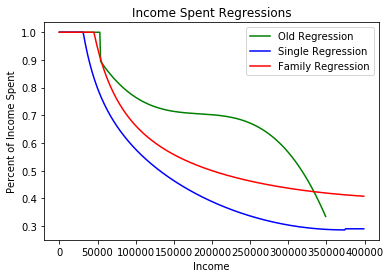

In [30]:
plt.plot(xOldRegression,yOldRegression, color = "g", label = "Old Regression")
plt.plot(xSingleRegression,ySingleRegression, color = "b", label = "Single Regression")
plt.plot(xFamilyRegression,yFamilyRegression, color = "r", label = "Family Regression")
plt.title("Income Spent Regressions")
plt.xlabel("Income")
plt.ylabel("Percent of Income Spent")
plt.legend()
plt.show()

### Income vs Expenditure plots

In [31]:
sortedIncomeSingleRegression = sorted(list(set(incomeRegressionSingle.FINCBTXM)))
singleIncomeRegressionExamples = []
for income in sortedIncomeSingleRegression:
    singleIncomeRegressionExamples.append(income * getExpendPercent(income, incomeRegressionSingle))
    
sortedIncomeFamilyRegression = sorted(list(set(incomeRegressionFamily.FINCBTXM)))
familyIncomeRegressionExamples = []
for income in sortedIncomeFamilyRegression:
    familyIncomeRegressionExamples.append(income * getExpendPercent(income, incomeRegressionFamily))

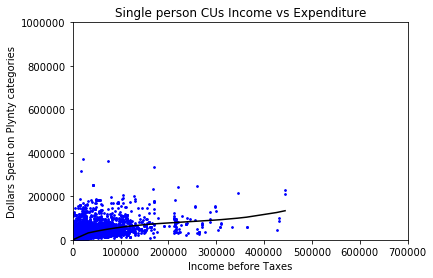

In [32]:
plt.scatter(incomeRegressionSingle.FINCBTXM, incomeRegressionSingle.TotalExp, color='b', s=3)
plt.plot(sortedIncomeSingleRegression, singleIncomeRegressionExamples, color = "black")
plt.xlabel("Income before Taxes")
plt.ylabel("Dollars Spent on Plynty categories")
plt.title("Single person CUs Income vs Expenditure")
plt.xlim(0,700000)
plt.ylim(0,1000000)
plt.show()

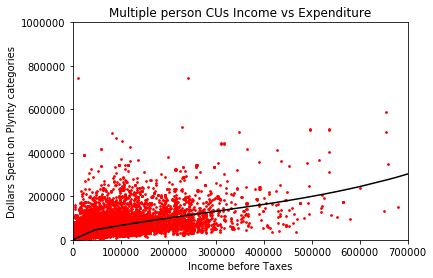

In [33]:
plt.scatter(incomeRegressionFamily.FINCBTXM, incomeRegressionFamily.TotalExp, color='r', s=3)
plt.plot(sortedIncomeFamilyRegression, familyIncomeRegressionExamples, color = "black")
plt.xlabel("Income before Taxes")
plt.ylabel("Dollars Spent on Plynty categories")
plt.title("Multiple person CUs Income vs Expenditure")
plt.xlim(0,700000)
plt.ylim(0,1000000)
plt.show()

## Income vs Expenditure Plots using FLMI Columns
- fmli columns: pre-made columns totals from the bls that deal with total expenditure

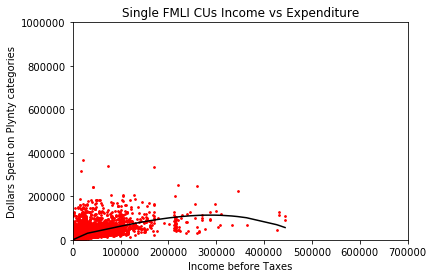

In [34]:
fmli = pd.concat([value for key,value in data.items() if 'fmli' in key.lower()], ignore_index=True)

SingleFlat = set()
for value in Single.values():
    SingleFlat = SingleFlat.union(value)

totalYearlyExpenditure = (fmli[fmli.NEWID.isin(SingleFlat)].TOTEXPCQ + fmli[fmli.NEWID.isin(SingleFlat)].TOTEXPPQ) * 4
totalYearlyIncome = fmli[fmli.NEWID.isin(SingleFlat)].FINCBTXM
testRegressionDF = pd.concat([totalYearlyIncome,totalYearlyExpenditure], axis=1, keys=['FINCBTXM', 'TotalExp'])
# testRegressionDF["FINCBTXM"] = totalYearlyIncome
# testRegressionDF["TotalExp"] = totalYearlyExpenditure
sortedtestRegression = sorted(list(set(testRegressionDF.FINCBTXM)))
testRegressionExamples = []
for income in sortedtestRegression:
    testRegressionExamples.append(income * getExpendPercent(income, testRegressionDF))
plt.plot(sortedtestRegression, testRegressionExamples, color = "black")
plt.scatter(totalYearlyIncome, totalYearlyExpenditure, color='r', s=3)
# plt.plot(sortedIncomeFamilyRegression, familyIncomeRegressionExamples, color = "black")
plt.xlabel("Income before Taxes")
plt.ylabel("Dollars Spent on Plynty categories")
plt.title("Single FMLI CUs Income vs Expenditure")
plt.xlim(0,700000)
plt.ylim(0,1000000)
plt.show()

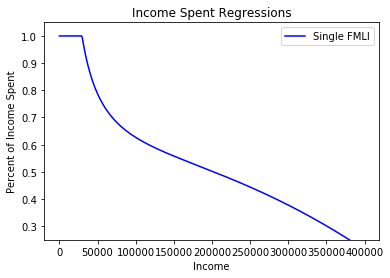

In [35]:
xTestRegression = range(0,400000,1000)

yTestRegression = []

for income in xTestRegression:
    yTestRegression.append(getExpendPercent(income, testRegressionDF))

TestTruncation = [yTestRegression.index(min(yTestRegression)) * 1000, round(min(yTestRegression),2)]
yTestRegression = []
for income in xTestRegression:
    yTestRegression.append(getExpendPercent(income, testRegressionDF, TestTruncation))
    
plt.plot(xTestRegression,yTestRegression, color = "b", label = "Single FMLI")
plt.title("Income Spent Regressions")
plt.xlabel("Income")
plt.ylabel("Percent of Income Spent")
plt.ylim(0.25,1.05)
plt.legend()
plt.show()

### Number of Users

In [36]:
singleCountNEWIDs = {}
for income in subsetNEWIDs["SingleIncome"]:
    newidSet = set()
    for year in subsetNEWIDs["Year"]:
        for month in subsetNEWIDs["Month"]:
            newidSet = newidSet.union(Single[(year,month,income)])
    singleCountNEWIDs[income] = len(newidSet)
    
familyCountNEWIDs = {}
for income in subsetNEWIDs["FamilyIncome"]:
    newidSet = set()
    for year in subsetNEWIDs["Year"]:
        for month in subsetNEWIDs["Month"]:
            newidSet = newidSet.union(Family[(year,month,income)])
    familyCountNEWIDs[income] = len(newidSet)

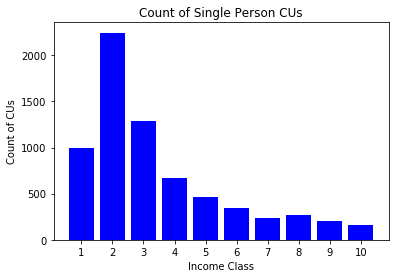

In [37]:
plt.bar(range(len(singleCountNEWIDs)), singleCountNEWIDs.values(), align='center', color='b')
plt.xticks(range(len(singleCountNEWIDs)), singleCountNEWIDs.keys())
plt.xlabel("Income Class")
plt.ylabel("Count of CUs")
plt.title("Count of Single Person CUs")
plt.show()

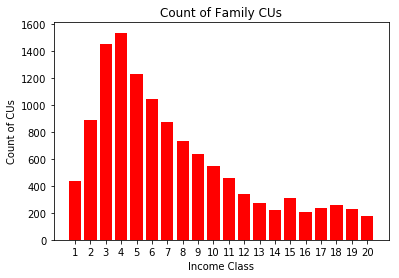

In [38]:
plt.bar(range(len(familyCountNEWIDs)), familyCountNEWIDs.values(), align='center', color='r')
plt.xticks(range(len(familyCountNEWIDs)), familyCountNEWIDs.keys())
plt.xlabel("Income Class")
plt.ylabel("Count of CUs")
plt.title("Count of Family CUs")
plt.show()

# Get Example Expenditures

In [39]:
income = 50000
single = True

if single:
    regressionDf = incomeRegressionSingle
    theIncomeBrackets = singleIncomeBrackets
    plyntyDf = plyntySingle
    truncation = SingleTruncation
else:
    regressionDf = incomeRegressionFamily
    theIncomeBrackets = familyIncomeBrackets
    plyntyDf = plyntyFamily
    truncation = FamilyTruncation

def getIncomeBracketIndex(income, theIncomeBrackets):
    incomebracket = 0
    for i in range(0,len(theIncomeBrackets)):
        if income <= theIncomeBrackets[i]:
            return(i-1)
    return(len(theIncomeBrackets)-1)

round((plyntyDf.iloc[getIncomeBracketIndex(income, theIncomeBrackets),:] * getExpendPercent(income, regressionDf, truncation) * income)/ 12, 2)

FoodAtHome                   321.04
FoodAway                     150.28
Housing                      707.04
OtherHousing                 327.35
Utilities                    286.85
ClothingAndBeauty             89.32
Transportation               579.34
Healthcare                   314.86
Entertainment                173.90
Miscellaneous                 58.85
CharitableAndFamilyGiving    269.60
Insurance                     28.36
Education                     16.17
Name: 5, dtype: float64

## Hospital room and services

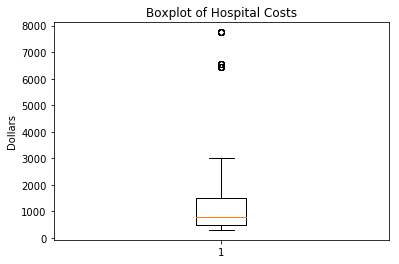

In [40]:
plt.boxplot(list(oneTimeSubsetMtbi.COST))
plt.title("Boxplot of Hospital Costs")
plt.ylabel("Dollars")
plt.show()